------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------



Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused. **Make sure you run all your code before submitting the notebook, and do not leave unnecessary print statements / cells in your notebook that are not intended for the grader.**

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [2]:
!python --version

Python 3.12.7


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [3]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
#from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [4]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [5]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [6]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


In [7]:
# Check the attributes of the first review
reviews[0].keys()

dict_keys(['cv', 'sentiment', 'content'])

In [8]:
def accuracy(true_labels, predicted_labels):
  """
  Compute the accuracy of a classification task.

  :param true_labels: list of true labels
  :param predicted_labels: list of predicted labels
  :return: accuracy
  """
  return sum(1 for tl, pl in zip(true_labels, predicted_labels) if tl == pl) / len(true_labels)

#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [9]:
# YOUR CODE HERE
# Load sentiment lexicon
sentiment_dict = {}
with open("sent_lexicon", "r", encoding="utf-8") as f:
    for line in f:
        # Split line into fields
        fields = line.strip().split()
        # Get word and polarity
        word = fields[2].lower().split("=")[1]
        polarity = fields[5].split("=")[1]
        # Add word to sentiment dictionary
        if polarity == "positive":
            sentiment_dict[word] = 1
        elif polarity == "negative":
            sentiment_dict[word] = -1
        # Skip neutral and both

def classify_review_binary(review, sentiment_dict, threshold=8):
    """
    Classify a review as positive or negative based on the sentiment of its tokens.

    :param review: a dictionary with a "content" field that contains a list of sentences,
                     each sentence being a list of (token, pos_tag) pairs.
    :param threshold: the sum of sentiment scores that is required to classify a review as positive.
    """
    score = 0
    for sentence in review["content"]:
        for token, _ in sentence:
            token = token.lower()
            if token in sentiment_dict:
                score += sentiment_dict[token]
    return "POS" if score > threshold else "NEG"

In [10]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.
# Evaluate on all reviews
token_results = []
for review in reviews:
    prediction = classify_review_binary(review, sentiment_dict)
    token_results.append(1 if prediction == review["sentiment"] else 0)

token_accuracy = sum(token_results) / len(token_results)
print(f"Accuracy: {token_accuracy:.3f}")

Accuracy: 0.678


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [11]:
# YOUR CODE HERE
weighted_sentiment_dict = {}
with open("sent_lexicon", "r", encoding="utf-8") as f:
    for line in f:
        fields = line.strip().split()
        word = fields[2].lower().split("=")[1]
        polarity = fields[5].split("=")[1]
        type = fields[0].split("=")[1]
        strength = 3 if type == "strongsubj" else 1
        if polarity == "positive":
            weighted_sentiment_dict[word] = strength
        elif polarity == "negative":
            weighted_sentiment_dict[word] = -strength

            

In [12]:
magnitude_results = []

for review in reviews:
    prediction = classify_review_binary(review, weighted_sentiment_dict, threshold=8)
    magnitude_results.append(1 if prediction == review["sentiment"] else 0)
    
magnitude_accuracy = sum(magnitude_results) / len(magnitude_results)
print(f"Accuracy: {magnitude_accuracy:.3f}")  # Using f-string formatting

Accuracy: 0.691


#### (Q.1.3) Make a barplot of the two results (0.5pt)

Text(1, 0.691, '0.691')

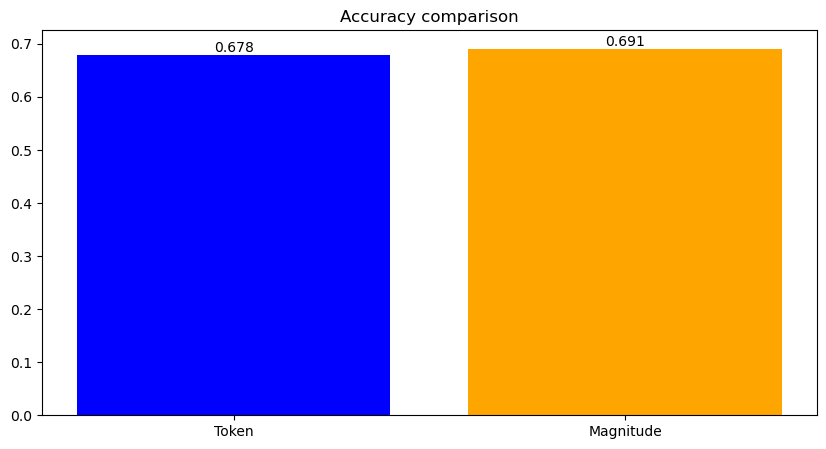

In [13]:
# YOUR CODE HERE
plt.figure(figsize=(10, 5))
plt.title("Accuracy comparison")
plt.bar(["Token", "Magnitude"], [token_accuracy, magnitude_accuracy], color=["blue", "orange"])
plt.text(0, token_accuracy, f"{token_accuracy:.3f}", ha="center", va="bottom")
plt.text(1, magnitude_accuracy, f"{magnitude_accuracy:.3f}", ha="center", va="bottom")

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

Awnser: The current fixed threshold approach is problematic because longer documents will  accumulate more sentiment words. This means longer positive reviews are more likely to be classified as positive simply because they have more words, not because they are more positive. Similarly, shorter positive reviews might be misclassified as negative just because they don't have enough words to exceed the threshold.

A better approach is to normalize the sentiment score by the document length
or by the number of sentiment words in the document. 

In [14]:
# YOUR CODE HERE
def classify_review_normalized(review, threshold=0.1):
    """
    Classify a review using a normalized sentiment score that accounts for document length.
    
    :param review: The review to classify
    :param threshold: Threshold for normalized score (default: 0.3)
    :return: "POS" or "NEG"
    """
    score = 0
    sentiment_words = 0
    
    # Count sentiment words and calculate score
    for sentence in review["content"]:
        for token, _ in sentence:
            token = token.lower()
            if token in sentiment_dict:
                score += sentiment_dict[token]
                sentiment_words += 1
    
    # Normalize score by number of sentiment words (if any found)
    if sentiment_words > 0:
        normalized_score = score / sentiment_words
    else:
        normalized_score = 0
        
    return "POS" if normalized_score > threshold else "NEG"

# Evaluate with normalized threshold
normalized_results = []
for review in reviews:
    prediction = classify_review_normalized(review)
    normalized_results.append(1 if prediction == review["sentiment"] else 0)

normalized_accuracy = sum(normalized_results) / len(normalized_results)
print(f"Accuracy with normalized threshold: {normalized_accuracy:.3f}")

# Compare with previous approach
print(f"Previous accuracy: {magnitude_accuracy:.3f}")

Accuracy with normalized threshold: 0.669
Previous accuracy: 0.691


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

Awnser: If words that were only seen in one sentiment class during training are skipped only for that class at test time, the probabilities for the other class become disproportionately high. This imbalance occurs because skipping words selectively biases the probability estimates, leading to an unfair advantage for the class where the word isn’t skipped. The Naive Bayes classifier may misclassify the test instance, especially when words indicative of a particular sentiment are excluded from one class but not the other.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [ ]:
import math  # Ensure math module is imported
import string  # For punctuation handling

train_reviews = [review for review in reviews if review["cv"] <= 899]
test_reviews = [review for review in reviews if review["cv"] > 899]

def class_prior_probability(train_reviews):
    pos_reviews = sum(1 for review in train_reviews if review["sentiment"] == "POS")
    neg_reviews = sum(1 for review in train_reviews if review["sentiment"] == "NEG")
    
    total_reviews = len(train_reviews)
    pos_prior = pos_reviews / total_reviews
    neg_prior = neg_reviews / total_reviews
    
    return {"POS": pos_prior, "NEG": neg_prior}

def get_features(reviews):
    """
    Processes reviews to extract features for each class by counting word frequencies.
    Converts tokens to lowercase and removes punctuation.
    Returns a dictionary with word counts for 'POS' and 'NEG' classes.
    """
    word_counts = {"POS": {}, "NEG": {}}
    total_words = {"POS": 0, "NEG": 0}

    for review in reviews:
        sentiment = review["sentiment"]
        for sentence in review["content"]:
            for token, _ in sentence:
                # Convert token to lowercase and strip punctuation
                token = token.lower().translate(str.maketrans('', '', string.punctuation))
                if token:
                    word_counts[sentiment][token] = word_counts[sentiment].get(token, 0) + 1
                    total_words[sentiment] += 1

    return word_counts, total_words

def calculate_likelihood(word_counts, total_words):
    """
    Calculates the likelihoods of words given sentiment labels using word counts.
    """
    likelihoods = {"POS": {}, "NEG": {}}
    
    for sentiment in ["POS", "NEG"]:
        for word, count in word_counts[sentiment].items():
            # Only include words that appear in both classes to reduce zero probabilities
            if word in word_counts["POS"] and word in word_counts["NEG"]:
                likelihoods[sentiment][word] = count / total_words[sentiment]

    return likelihoods


def naive_bayes_prediction(review, prior_probabilities, word_likelihoods):
    scores = {
        "POS": math.log(prior_probabilities["POS"]),
        "NEG": math.log(prior_probabilities["NEG"])
    }
    
    for sentence in review["content"]:
        for token, _ in sentence:
            token = token.lower().translate(str.maketrans('', '', string.punctuation))
            if token in word_likelihoods["POS"]:
                scores["POS"] += math.log(word_likelihoods["POS"][token])
            if token in word_likelihoods["NEG"]:
                scores["NEG"] += math.log(word_likelihoods["NEG"][token])
    
    return max(scores, key=scores.get)


def evaluate_naive_bayes(train_reviews, test_reviews):
    """
    Train a Naive Bayes classifier using a specified likelihood function.
    
    :param train_reviews: The training reviews
    :param likelihood_func: The likelihood function to use (with or without smoothing)
    :return: Prior probabilities and word likelihoods
    """
       # Calculate priors and likelihoods
    prior_probabilities = class_prior_probability(train_reviews)
    word_counts, total_words = get_features(train_reviews)
    word_likelihoods = calculate_likelihood(word_counts, total_words)
    
    # Training accuracy
    train_true_labels = [review["sentiment"] for review in train_reviews]
    train_predicted_labels = [naive_bayes_prediction(review, prior_probabilities, word_likelihoods)
                              for review in train_reviews]
    train_accuracy = accuracy(train_true_labels, train_predicted_labels)
    
    # Test accuracy
    test_true_labels = [review["sentiment"] for review in test_reviews]
    test_predicted_labels = [naive_bayes_prediction(review, prior_probabilities, word_likelihoods)
                             for review in test_reviews]
    test_accuracy = accuracy(test_true_labels, test_predicted_labels)
    
    return prior_probabilities, word_likelihoods, train_accuracy, test_accuracy

# Run training with the modified code
train_prior_probabilities, train_word_likelihoods, train_nb_accuracy, test_nb_accuracy = evaluate_naive_bayes(train_reviews, test_reviews)
print(f"Training accuracy: {train_nb_accuracy:.3f}")
print(f"Test accuracy: {test_nb_accuracy:.3f}")

{'POS': {'films': 749, 'adapted': 24, 'from': 2399, 'comic': 200, 'books': 45, 'have': 2047, 'had': 667, 'plenty': 68, 'of': 16569, 'success': 111, 'whether': 119, 'they': 2084, 're': 391, 'about': 1508, 'superheroes': 8, 'lrb': 5385, 'batman': 43, 'superman': 5, 'spawn': 10, 'rrb': 5410, 'or': 1305, 'geared': 5, 'toward': 50, 'kids': 152, 'casper': 6, 'the': 36898, 'arthouse': 2, 'crowd': 29, 'ghost': 55, 'world': 584, 'but': 3987, 'there': 1531, 's': 8536, 'never': 640, 'really': 689, 'been': 883, 'a': 17955, 'book': 158, 'like': 1546, 'hell': 92, 'before': 445, 'for': 4651, 'starters': 3, 'it': 7383, 'was': 2310, 'created': 95, 'by': 3203, 'alan': 50, 'moore': 39, 'and': 17609, 'eddie': 57, 'campbell': 52, 'who': 2775, 'brought': 83, 'medium': 14, 'to': 14648, 'whole': 204, 'new': 642, 'level': 104, 'in': 10432, 'mid': 6, '80s': 25, 'with': 5243, '12part': 1, 'series': 222, 'called': 142, 'watchmen': 1, 'say': 344, 'thoroughly': 29, 'researched': 1, 'subject': 86, 'jack': 149, 'ripp

#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

TODO: Edit this??? In the case of imbalanced classes, accuracy would not be a reliable metric to evaluate the classifier. This is because accuracy is a biased metric. A classifier that simply predicts every review as positive would achieve 90% accuracy without actually learning meaningful distinctions between positive and negative reviews.

In [40]:
negative_reviews_train = [review for review in reviews if review["cv"] <= 89]
test_reviews = [review for review in reviews if review["cv"] >= 900 and review["cv"] <= 909]

# Train two separate classifiers
negative_prior_probabilities, negative_word_likelihoods, train_accuracy, test_accuracy = evaluate_naive_bayes(negative_reviews_train, test_reviews)
print(f"Accuracy after training on only negative reviews: {test_accuracy:.3f}")

Accuracy after training on only negative reviews: 0.550


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)} \text{for a word $w_i$ becomes} \frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [45]:
# YOUR CODE HERE
def calculate_smoothed_likelihood(word_counts, total_words, kappa=1):
    """
    Calculates smoothed likelihoods for each word in the vocabulary given the training data.
    
    :param word_counts: Dictionary with word counts for each class ('POS' and 'NEG')
    :param total_words: Total word count for each class
    :param kappa: Smoothing parameter (default: 1)
    :return: Smoothed likelihoods for each word in the vocabulary for both classes
    """
    vocabulary = set(word for sentiment in word_counts for word in word_counts[sentiment])  # Create vocabulary from word counts
    vocabulary_size = len(vocabulary)

    likelihoods = {"POS": {}, "NEG": {}}
    for sentiment in ["POS", "NEG"]:
        for word in vocabulary:
            count = word_counts[sentiment].get(word, 0)
            # Apply smoothing to the likelihood calculation
            likelihoods[sentiment][word] = (count + kappa) / ((total_words[sentiment] + kappa) * vocabulary_size)

    return likelihoods

def evaluate_naive_bayes_smoothed(train_reviews, test_reviews):
    """
    Train a Naive Bayes classifier using a specified likelihood function.
    
    :param train_reviews: The training reviews
    :param likelihood_func: The likelihood function to use (with or without smoothing)
    :return: Prior probabilities and word likelihoods
    """
       # Calculate priors and likelihoods
    prior_probabilities = class_prior_probability(train_reviews)
    word_counts, total_words = get_features(train_reviews)
    word_likelihoods = calculate_smoothed_likelihood(word_counts, total_words)
    
    # Training accuracy
    train_true_labels = [review["sentiment"] for review in train_reviews]
    train_predicted_labels = [naive_bayes_prediction(review, prior_probabilities, word_likelihoods)
                              for review in train_reviews]
    train_accuracy = accuracy(train_true_labels, train_predicted_labels)
    
    # Test accuracy
    test_true_labels = [review["sentiment"] for review in test_reviews]
    test_predicted_labels = [naive_bayes_prediction(review, prior_probabilities, word_likelihoods)
                             for review in test_reviews]
    test_accuracy = accuracy(test_true_labels, test_predicted_labels)
    
    return prior_probabilities, word_likelihoods, train_accuracy, test_accuracy


# Evaluate the Naive Bayes classifier with smoothing
train_prior_probabilities, train_word_likelihoods, train_nb_accuracy, test_nb_accuracy = evaluate_naive_bayes_smoothed(train_reviews,test_reviews)
print(f"Training accuracy with smoothing: {train_nb_accuracy:.3f}")
print(f"Test accuracy with smoothing: {test_nb_accuracy:.3f}")

Training accuracy with smoothing: 0.972
Test accuracy with smoothing: 0.750


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [18]:
# YOUR CODE HERE

def round_robin_split(data, num_folds=10):
    """
    Splits data into folds based on a round-robin (mod) approach.

    :param data: list of samples
    :param num_folds: number of folds (default: 10)
    :return: list of folds, where each fold is a list of samples
    """
    folds = [[] for _ in range(num_folds)]
    for i, sample in enumerate(data):
        folds[i % num_folds].append(sample)
    return folds


In [47]:
def cross_validate(data, num_folds=10):
    """
    Performs 10-fold cross-validation using round-robin splitting for Naive Bayes.

    :param data: list of samples, each with 'content' and 'sentiment' fields
    :param num_folds: number of folds for cross-validation (default: 10)
    :param kappa: smoothing parameter for Naive Bayes
    :return: average accuracy across folds
    """
    folds = round_robin_split(data, num_folds)
    fold_accuracies = []
    
    for i in range(num_folds):
        # Prepare training and testing sets for the current fold
        test_data = folds[i]
        train_data = [item for j, fold in enumerate(folds) if j != i for item in fold]
        
        # Evaluate Naive Bayes model using the provided evaluate function
        _, _, train_accuracy, test_accuracy = evaluate_naive_bayes_smoothed(
            train_data, test_data
        )
        
        # Record the test accuracy for the current fold
        fold_accuracies.append(test_accuracy)
        print(f"Fold {i+1} test accuracy: {test_accuracy:.3f}")

    # Calculate and report the average accuracy across folds
    avg_accuracy = np.mean(fold_accuracies)
    print(f"Average cross-validation accuracy: {avg_accuracy:.3f}")
    return avg_accuracy, fold_accuracies


average_accuracy, fold_accuracies = cross_validate(reviews, num_folds=10)

Fold 1 test accuracy: 0.770
Fold 2 test accuracy: 0.845
Fold 3 test accuracy: 0.795
Fold 4 test accuracy: 0.845
Fold 5 test accuracy: 0.785
Fold 6 test accuracy: 0.840
Fold 7 test accuracy: 0.825
Fold 8 test accuracy: 0.760
Fold 9 test accuracy: 0.815
Fold 10 test accuracy: 0.810
Average cross-validation accuracy: 0.809


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [48]:
# YOUR CODE HERE
def calculate_variance(scores):
    """
    Calculate the variance of a list of scores.

    :param scores: List of accuracy scores 
    :return: Variance of the scores
    """
    mean_score = sum(scores) / len(scores)
    variance = sum((score - mean_score) ** 2 for score in scores) / (len(scores) -1)
    return variance

print(calculate_variance(fold_accuracies))

0.0009488888888888875


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [49]:
# YOUR CODE HERE
from nltk.stem import PorterStemmer
import string

def preprocess_and_stem(reviews):
    stemmer = PorterStemmer()
    processed_reviews = []

    for review in reviews:
        sentiment = review["sentiment"]
        # Initialize a new review for processed content
        processed_content = []
        for sentence in review["content"]:
            # Stem each token in the sentence
            stemmed_sentence = [(stemmer.stem(token.lower().translate(str.maketrans('', '', string.punctuation))), None) 
                                for token, _ in sentence]
            processed_content.append(stemmed_sentence)
        
        processed_reviews.append({"sentiment": sentiment, "content": processed_content})

    return processed_reviews

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [50]:
# YOUR ANSWER HERE
processed_reviews = preprocess_and_stem(reviews)
average_accuracy, fold_accuracies = cross_validate(processed_reviews, num_folds=10)

Fold 1 test accuracy: 0.775
Fold 2 test accuracy: 0.835
Fold 3 test accuracy: 0.805
Fold 4 test accuracy: 0.865
Fold 5 test accuracy: 0.800
Fold 6 test accuracy: 0.840
Fold 7 test accuracy: 0.815
Fold 8 test accuracy: 0.750
Fold 9 test accuracy: 0.830
Fold 10 test accuracy: 0.805
Average cross-validation accuracy: 0.812


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

Awnser: As we see from the output of the code bellow the number of features decreases from 46817 without stemming to 33230 with stemming.

In [81]:
# YOUR CODE HERE
feature_count_no_stemming, total_words_no_stemming = get_features(reviews)
total_features_no_stemming = len(feature_count_no_stemming['POS']) + len(feature_count_no_stemming['NEG'])
print(f"Total number of features (without stemming): {total_features_no_stemming}")


# Calculate vocabulary size with stemming
processed_reviews = preprocess_and_stem(reviews)

feature_count_no_stemming, total_words_no_stemming = get_features(processed_reviews)
total_features_no_stemming = len(feature_count_no_stemming['POS']) + len(feature_count_no_stemming['NEG'])
print(f"Total number of features (with stemming): {total_features_no_stemming}")


Total number of features (without stemming): 66511
Total number of features (with stemming): 47103


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [63]:
# YOUR CODE HERE
from nltk import ngrams

def get_features_ngrams(reviews, n=1):
    """
    Processes reviews to extract n-gram features for each class by counting frequencies.
    Converts tokens to lowercase and removes punctuation.
    Returns a dictionary with n-gram counts for 'POS' and 'NEG' classes.
    
    :param reviews: List of reviews with "content" field containing tokenized sentences.
    :param n: The upper limit for n-grams (1 for unigrams, 2 for bigrams, etc.).
    """
    ngram_counts = {"POS": {}, "NEG": {}}
    total_ngrams = {"POS": 0, "NEG": 0}

    for review in reviews:
        sentiment = review["sentiment"]
        for sentence in review["content"]:
            # Prepare a list of tokens, stripping punctuation
            tokens = [token.lower().translate(str.maketrans('', '', string.punctuation)) for token, _ in sentence if token]
            
            # Generate n-grams up to the specified limit n
            for n_ in range(1, n + 1):  # Loop through 1 to n (inclusive)
                for n_gram in ngrams(tokens, n_):
                    n_gram_str = ' '.join(n_gram)  # Concatenate n-gram tuple into a string
                    ngram_counts[sentiment][n_gram_str] = ngram_counts[sentiment].get(n_gram_str, 0) + 1
                    total_ngrams[sentiment] += 1

    return ngram_counts, total_ngrams



In [ ]:
def evaluate_naive_bayes_ngrams(train_reviews, test_reviews, n):
    """
    Train a Naive Bayes classifier using a specified likelihood function.
    
    :param train_reviews: The training reviews
    :param likelihood_func: The likelihood function to use (with or without smoothing)
    :return: Prior probabilities and word likelihoods
    """
       # Calculate priors and likelihoods
    prior_probabilities = class_prior_probability(train_reviews)
    word_counts, total_words = get_features_ngrams(train_reviews, n)
    word_likelihoods = calculate_likelihood(word_counts, total_words)
    
    # Training accuracy
    train_true_labels = [review["sentiment"] for review in train_reviews]
    train_predicted_labels = [naive_bayes_prediction(review, prior_probabilities, word_likelihoods)
                              for review in train_reviews]
    train_accuracy = accuracy(train_true_labels, train_predicted_labels)
    
    # Test accuracy
    test_true_labels = [review["sentiment"] for review in test_reviews]
    test_predicted_labels = [naive_bayes_prediction(review, prior_probabilities, word_likelihoods)
                             for review in test_reviews]
    test_accuracy = accuracy(test_true_labels, test_predicted_labels)
    
    return prior_probabilities, word_likelihoods, train_accuracy, test_accuracy

# prior_probabilities, word_likelihoods, train_accuracy, test_accuracy = evaluate_naive_bayes_ngrams(train_reviews, test_reviews, 2)

# print(test_accuracy)

0.825


In [67]:
def cross_validate(data, n, num_folds=10):
    """
    Performs 10-fold cross-validation using round-robin splitting for Naive Bayes.

    :param data: list of samples, each with 'content' and 'sentiment' fields
    :param num_folds: number of folds for cross-validation (default: 10)
    :param kappa: smoothing parameter for Naive Bayes
    :return: average accuracy across folds
    """
    folds = round_robin_split(data, num_folds)
    fold_accuracies = []
    
    for i in range(num_folds):
        # Prepare training and testing sets for the current fold
        test_data = folds[i]
        train_data = [item for j, fold in enumerate(folds) if j != i for item in fold]
        
        # Evaluate Naive Bayes model using the provided evaluate function
        _, _, train_accuracy, test_accuracy = evaluate_naive_bayes_ngrams(
            train_data, test_data, n
        )
        
        # Record the test accuracy for the current fold
        fold_accuracies.append(test_accuracy)
        print(f"Fold {i+1} test accuracy: {test_accuracy:.3f}")

    # Calculate and report the average accuracy across folds
    avg_accuracy = np.mean(fold_accuracies)

    return avg_accuracy, fold_accuracies


average_accuracy_bigrams, _ = cross_validate(reviews, 2, num_folds=10)


average_accuracy_trigrams, _ = cross_validate(reviews, 3, num_folds=10)
print(f"Average cross-validation accuracy for unigrams + bigrams : {average_accuracy_bigrams:.3f}")
print(f"Average cross-validation accuracy for  unigrams + bigrams + trigrams: {average_accuracy_trigrams:.3f}")

Fold 1 test accuracy: 0.765
Fold 2 test accuracy: 0.820
Fold 3 test accuracy: 0.790
Fold 4 test accuracy: 0.865
Fold 5 test accuracy: 0.810
Fold 6 test accuracy: 0.845
Fold 7 test accuracy: 0.815
Fold 8 test accuracy: 0.790
Fold 9 test accuracy: 0.835
Fold 10 test accuracy: 0.785
Fold 1 test accuracy: 0.765
Fold 2 test accuracy: 0.815
Fold 3 test accuracy: 0.775
Fold 4 test accuracy: 0.850
Fold 5 test accuracy: 0.800
Fold 6 test accuracy: 0.845
Fold 7 test accuracy: 0.805
Fold 8 test accuracy: 0.790
Fold 9 test accuracy: 0.820
Fold 10 test accuracy: 0.780
Average cross-validation accuracy for unigrams + bigrams : 0.812
Average cross-validation accuracy for  unigrams + bigrams + trigrams: 0.804



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How do the number of features increase in the held-out training set (compared to Q2.8)? Do you expect this rate of increase to continue for (much) larger n-grams?

Use the held-out training set once again for this.


Awnser: We theoretically expect the number to increase exponentially since we get .... ????????????

In [77]:
# YOUR CODE HERE
# Count features for unigrams
feature_count_unigram, _ = get_features_ngrams(reviews, 1)
total_features_unigrams = len(feature_count_unigram['POS']) + len(feature_count_unigram['NEG'])
print(f"Total number of features (unigrams): {total_features_unigrams}")

# Count features for unigrams + bigrams
feature_count_unigram_bigram, _ = get_features_ngrams(reviews, 2)
total_features_unigrams_bigrams = len(feature_count_unigram_bigram['POS']) + len(feature_count_unigram_bigram['NEG'])
print(f"Total number of features (unigrams + bigrams): {total_features_unigrams_bigrams}")

# Count features for unigrams + bigrams + trigrams
feature_count_unigram_bigram_trigram, _ = get_features_ngrams(reviews, 3)
total_features_unigrams_bigrams_trigrams = len(feature_count_unigram_bigram_trigram['POS']) + len(feature_count_unigram_bigram_trigram['NEG'])
print(f"Total number of features (unigrams + bigrams + trigrams): {total_features_unigrams_bigrams_trigrams}")


Total number of features (unigrams): 66513
Total number of features (unigrams + bigrams): 574300
Total number of features (unigrams + bigrams + trigrams): 1586543


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [37]:
# YOUR CODE HERE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Prepare data for vectorization
train_texts = [" ".join([token.lower().translate(str.maketrans('', '', string.punctuation)) 
                         for sentence in review["content"] for token, _ in sentence])
               for review in train_reviews]
test_texts = [" ".join([token.lower().translate(str.maketrans('', '', string.punctuation)) 
                        for sentence in review["content"] for token, _ in sentence])
              for review in test_reviews]

# Vectorize texts
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_texts)
y_train = [review["sentiment"] for review in train_reviews]
X_test = vectorizer.transform(test_texts)
y_test = [review["sentiment"] for review in test_reviews]

# SVM with cross-validation
svm_clf = LinearSVC()
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=5)

print(f"SVM Mean CV Accuracy: {np.mean(svm_scores):.3f}")


c:\Users\marom\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\marom\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


SVM Mean CV Accuracy: 0.823


c:\Users\marom\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [27]:
# YOUR CODE HERE

*Write your answer here.*

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [28]:
# YOUR CODE HERE

*Write your answer here.*

# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


# Submission


In [29]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.